# Regresión lineal sobre CSV (test.csv)

Este cuaderno carga un CSV, selecciona automáticamente variables numéricas para entrenar un modelo de **regresión lineal**, evalúa el desempeño y muestra gráficas de diagnóstico.

- Ruta preferida: `notebooks/Classification Models/test.csv`
- Respaldo: `notebooks/test.csv`

Ajusta la variable objetivo si es necesario en la celda de selección de variables.


## Imports y configuración
Librerías, estilo de gráficos y rutas de entrada preferidas/alternativas.


In [184]:
# Imports y utilidades
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuración visual
sns.set(style="whitegrid", context="notebook")
# Tamaño global ms compacto y consistente
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["figure.dpi"] = 110
plt.rcParams["savefig.dpi"] = 150

# Ruta preferida y respaldo
PRIMARY_PATH = Path(r"notebooks/Classification Models/test.csv")
FALLBACK_PATH = Path(r"notebooks/test.csv")

# También intentar con ruta absoluta proporcionada por el usuario (Windows)
USER_ABS_PATH = Path(r"C:/Users/INMORTAL/OneDrive/Documentos/python/notebooks/Classification Models/test.csv")



## Carga del CSV
Intenta varias rutas (preferida, respaldo y absoluta en Windows). Muestra forma del `DataFrame` y primeras filas para verificación rápida.


In [185]:
# Carga del CSV con respaldo

def load_csv_with_fallback():
    candidate_paths = [
        USER_ABS_PATH,
        PRIMARY_PATH,
        FALLBACK_PATH,
    ]
    for p in candidate_paths:
        if p is not None and Path(p).exists():
            print(f"Cargando: {p}")
            return pd.read_csv(p)
    raise FileNotFoundError(
        f"No se encontró el CSV en: {candidate_paths}. Verifica la ruta."
    )

try:
    df = load_csv_with_fallback()
except Exception as e:
    print("Error cargando CSV:", e)
    raise

print("Forma del DataFrame:", df.shape)
df.head()


Cargando: C:\Users\INMORTAL\OneDrive\Documentos\python\notebooks\Classification Models\test.csv
Forma del DataFrame: (300, 2)


,x,y
0,77,79.775152
1,21,23.177279
2,22,25.609262
3,20,17.857388
4,36,41.849864


## Análisis exploratorio (EDA)
Vista rápida de encabezados, info, descripción estadística y nulos para validar calidad de datos antes del modelado.


,x,y
0,77,79.775152
1,21,23.177279
2,22,25.609262
3,20,17.857388
4,36,41.849864


,x,y
295,71,68.545888
296,46,47.334876
297,55,54.090637
298,62,63.297171
299,47,52.459467



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       300 non-null    int64  
 1   y       300 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.8 KB


,count,mean,std,min,5%,25%,50%,75%,95%,max,skewness,kurtosis,missing,zeros,uniques,IQR,CV
x,300.0,50.936667,28.504286,0.000000,5.000000,27.000000,53.000000,73.000000,96.000000,100.000000,-0.007086,-1.115701,0,3,97,46.000000,0.559602
y,300.0,51.205051,29.071481,-3.467884,7.399046,25.676502,52.170557,74.303007,97.109759,105.591837,-0.003111,-1.081200,0,0,300,48.626505,0.567746



Nulos por columna:
 x    0
y    0
dtype: int64


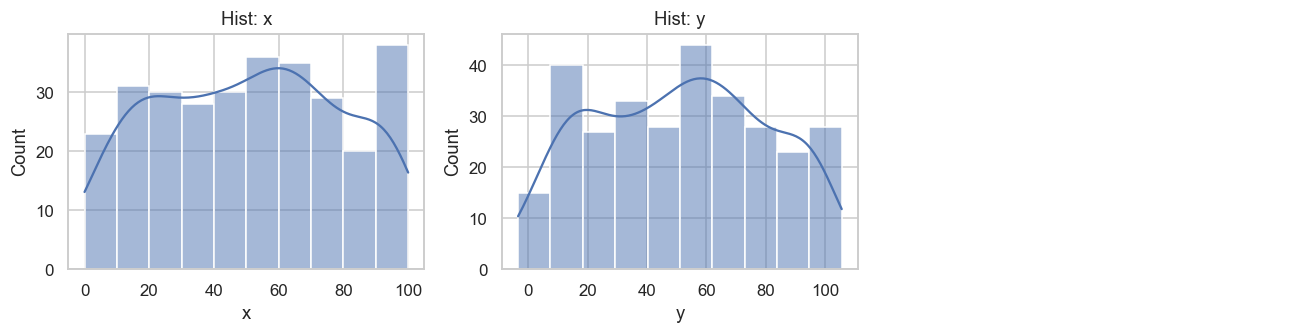

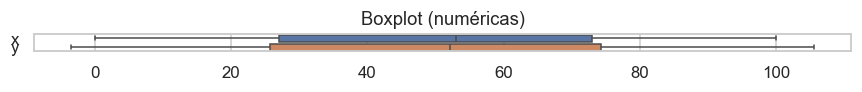

In [186]:
# EDA básica y estadística descriptiva ampliada

# Vista rápida
display(df.head())
display(df.tail())
print("\nInfo:")
df.info()

# Descriptivos ampliados (solo numéricas)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

num_df = df.select_dtypes(include=[np.number]).copy()

if not num_df.empty:
    desc = num_df.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T
    skew = num_df.skew(numeric_only=True)
    kurt = num_df.kurtosis(numeric_only=True)
    missing = num_df.isna().sum()
    zeros = (num_df == 0).sum()
    uniques = num_df.nunique()
    iqr = desc['75%'] - desc['25%']
    cv = desc['std'] / desc['mean']

    extended = desc.assign(
        skewness=skew,
        kurtosis=kurt,
        missing=missing,
        zeros=zeros,
        uniques=uniques,
        IQR=iqr,
        CV=cv
    )
    display(extended)
else:
    print("No hay columnas numéricas para estadística descriptiva.")

# Resumen de nulos (todas las columnas)
null_summary = df.isna().sum().sort_values(ascending=False)
print("\nNulos por columna:\n", null_summary.head(20))

# Gráficos compactos: histogramas por variable numérica
if not num_df.empty:
    cols = list(num_df.columns)
    n = len(cols)
    ncols = 3
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3.2 * nrows))
    axes = np.array(axes).reshape(nrows, ncols)
    for idx, col in enumerate(cols):
        r, c = divmod(idx, ncols)
        ax = axes[r, c]
        sns.histplot(num_df[col].dropna(), kde=True, ax=ax)
        ax.set_title(f"Hist: {col}")
    # Apagar ejes sobrantes
    for j in range(n, nrows * ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis('off')
    plt.tight_layout()
    plt.show()

    # Boxplot horizontal para outliers
    plt.figure(figsize=(8, 0.5 * max(1, len(cols))))
    sns.boxplot(data=num_df, orient='h')
    plt.title('Boxplot (numéricas)')
    plt.tight_layout()
    plt.show()


In [198]:
df.describe

<bound method NDFrame.describe of       x          y
0    77  79.775152
1    21  23.177279
2    22  25.609262
3    20  17.857388
4    36  41.849864
..   ..        ...
295  71  68.545888
296  46  47.334876
297  55  54.090637
298  62  63.297171
299  47  52.459467

[300 rows x 2 columns]>

In [199]:
data = df
data.describe()

,x,y
count,300.000000,300.000000
mean,50.936667,51.205051
std,28.504286,29.071481
min,0.000000,-3.467884
25%,27.000000,25.676502
50%,53.000000,52.170557
75%,73.000000,74.303007
max,100.000000,105.591837


In [200]:
data.isnull().sum()

x    0
y    0
dtype: int64

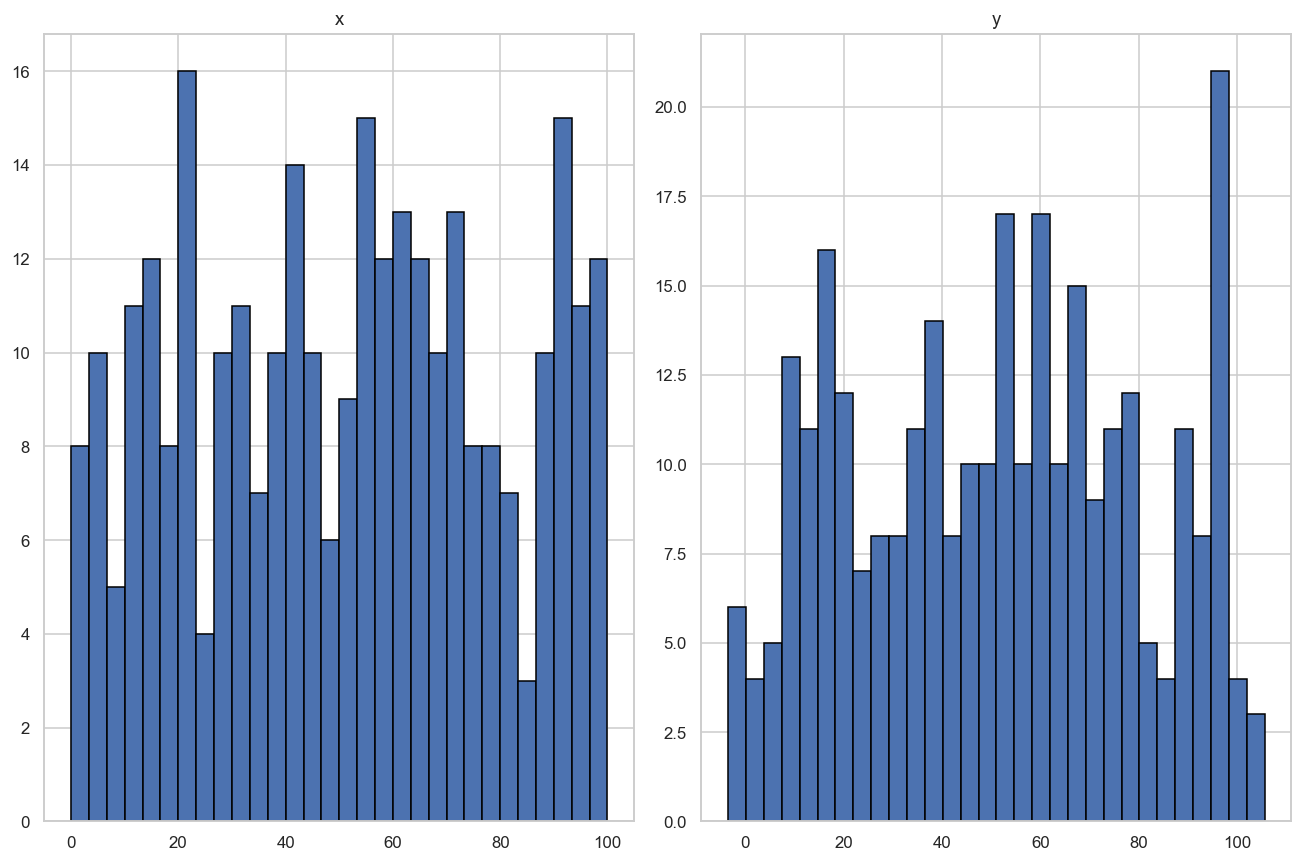

In [201]:
# Opción 1: usar df directamente
df.hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.tight_layout()

In [205]:
df.head()

,x,y
0,77,79.775152
1,21,23.177279
2,22,25.609262
3,20,17.857388
4,36,41.849864


In [206]:
df.tail()

,x,y
295,71,68.545888
296,46,47.334876
297,55,54.090637
298,62,63.297171
299,47,52.459467


## Selección de variables (X, y)
Detecta automáticamente la columna objetivo si existe (p.ej., `y`, `target`, `label`). Toma todas las variables numéricas restantes como características.

- Si no se detecta, usa la última columna como objetivo por defecto.



In [187]:
# Selección de variables

# Intenta detectar automáticamente la columna objetivo si existe alguna llamada 'target' o similar
possible_targets = [
    'target', 'Target', 'y', 'Y', 'label', 'Label', 'precio', 'Price', 'Valor', 'valor'
]
existing_targets = [c for c in possible_targets if c in df.columns]

if existing_targets:
    target_col = existing_targets[0]
else:
    # Si no hay una obvia, el usuario puede definirla aquí manualmente
    # target_col = 'NOMBRE_DE_TU_OBJETIVO'
    # Como fallback, usar la última columna
    target_col = df.columns[-1]

print(f"Usando columna objetivo: {target_col}")

numeric_df = df.select_dtypes(include=[np.number]).copy()

if target_col not in numeric_df.columns:
    # Intentar convertir si es posible
    try:
        numeric_df[target_col] = pd.to_numeric(df[target_col], errors='coerce')
    except Exception:
        pass

# Eliminar filas con NaN en objetivo
numeric_df = numeric_df.dropna(subset=[target_col])

# X = todas las numéricas excepto objetivo
feature_cols = [c for c in numeric_df.columns if c != target_col]
X = numeric_df[feature_cols]
y = numeric_df[target_col]

print(f"Características: {len(feature_cols)} -> {feature_cols[:10]}{'...' if len(feature_cols)>10 else ''}")
print(f"Muestras tras limpieza: {len(X)}")


Usando columna objetivo: y
Características: 1 -> ['x']
Muestras tras limpieza: 300


## Modelo Base (scikit-learn LinearRegression)
Entrenamiento y evaluación con `LinearRegression` sin escalado previo. Sirve como línea base para comparar con OLS y con el Pipeline que incluye estandarización.

- Métricas reportadas: MAE, RMSE, R².


In [188]:
# Entrenamiento de regresión lineal

if X.shape[1] == 0:
    raise ValueError("No hay variables numéricas para entrenar el modelo. Revisa el CSV.")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2:   {r2:.4f}")


MAE:  2.5178
RMSE: 3.0429
R2:   0.9909


## Dependencia opcional: statsmodels
Si no tienes `statsmodels` instalado, esta celda intentará instalarlo automáticamente. Requerido para OLS y pruebas estadísticas.



In [189]:
# Dependencia opcional: instalar statsmodels si no está disponible
try:
    import statsmodels.api as sm  # noqa: F401
    print("statsmodels ya está disponible.")
except ModuleNotFoundError:
    import sys
    print("Instalando statsmodels...")
    !{sys.executable} -m pip install -q --upgrade pip
    !{sys.executable} -m pip install -q statsmodels
    import statsmodels.api as sm
    print("statsmodels instalado.")



statsmodels ya está disponible.


## Modelo OLS (statsmodels)
Entrena un modelo OLS para análisis estadístico: coeficientes con errores estándar, pruebas t, intervalos de confianza y resumen detallado. Útil para interpretar efectos y validar supuestos.

- Métricas reportadas: MAE, RMSE, R² sobre el conjunto de prueba.
- Extras: QQ-plot, influencia y Cook's D disponibles más adelante.



In [190]:
# Modelo OLS (statsmodels): resumen y métricas
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Asegurar constante e interpretar coeficientes
X_train_const = sm.add_constant(X_train, has_constant='add')
X_test_const = sm.add_constant(X_test, has_constant='add')

ols_model = sm.OLS(y_train, X_train_const).fit()
print(ols_model.summary())

# Evaluación OLS
y_pred_ols = ols_model.predict(X_test_const)
mae_ols = mean_absolute_error(y_test, y_pred_ols)
rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))
r2_ols = r2_score(y_test, y_pred_ols)
print(f"\n[OLS] MAE: {mae_ols:.4f} | RMSE: {rmse_ols:.4f} | R2: {r2_ols:.4f}")



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 2.054e+04
Date:                Wed, 15 Oct 2025   Prob (F-statistic):          5.36e-233
Time:                        14:59:46   Log-Likelihood:                -606.13
No. Observations:                 240   AIC:                             1216.
Df Residuals:                     238   BIC:                             1223.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3619      0.412     -0.879      0.3

In [207]:
import statsmodels.api as sm

X = df[['x']]               # reemplaza 'x' por tus features
X = sm.add_constant(X)      # añade intercepto
y = df['y']                 # reemplaza 'y' por tu objetivo

ols = sm.OLS(y, X).fit()
print(ols.summary())

# Predicciones
y_pred_ols = ols.predict(X)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 2.709e+04
Date:                Wed, 15 Oct 2025   Prob (F-statistic):          1.33e-294
Time:                        15:09:55   Log-Likelihood:                -757.98
No. Observations:                 300   AIC:                             1520.
Df Residuals:                     298   BIC:                             1527.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4618      0.360     -1.284      0.2

In [208]:
import statsmodels.formula.api as smf

modelo = smf.ols('y ~ x', data=df).fit()   # cambia la fórmula, ej: 'y ~ x1 + x2'
print(modelo.summary())

y_pred = modelo.predict(df)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 2.709e+04
Date:                Wed, 15 Oct 2025   Prob (F-statistic):          1.33e-294
Time:                        15:10:39   Log-Likelihood:                -757.98
No. Observations:                 300   AIC:                             1520.
Df Residuals:                     298   BIC:                             1527.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4618      0.360     -1.284      0.2

In [209]:
import statsmodels.api as sm

# X e y (ajusta los nombres de columnas)
X = df[['x']]                  # o varias: df[['x1','x2',...]]
X = sm.add_constant(X)         # intercepto
y = df['y']

# RLM con pérdida de Huber
rlm_model = sm.RLM(y, X, M=sm.robust.norms.HuberT())
rlm_results = rlm_model.fit()
print(rlm_results.summary())

# Predicciones
y_pred_rlm = rlm_results.predict(X)

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  300
Model:                            RLM   Df Residuals:                      298
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 15 Oct 2025                                         
Time:                        15:11:50                                         
No. Iterations:                    14                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5243      0.370     -1.416      0.1

## Modelo scikit-learn con Pipeline
Estandariza las features con `StandardScaler` y entrena una `LinearRegression`. Comparar sus métricas con OLS ayuda a decidir entre inferencia (OLS) y despliegue (SK).

- Métricas reportadas: MAE, RMSE, R².



In [191]:
# Modelo de scikit-learn con Pipeline (StandardScaler + LinearRegression)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

sk_pipeline = Pipeline([
    ("scaler", StandardScaler(with_mean=True)),
    ("linreg", LinearRegression())
])

sk_pipeline.fit(X_train, y_train)

y_pred_sk = sk_pipeline.predict(X_test)
mae_sk = mean_absolute_error(y_test, y_pred_sk)
rmse_sk = np.sqrt(mean_squared_error(y_test, y_pred_sk))
r2_sk = r2_score(y_test, y_pred_sk)

print(f"[SK Pipeline] MAE: {mae_sk:.4f} | RMSE: {rmse_sk:.4f} | R2: {r2_sk:.4f}")



[SK Pipeline] MAE: 2.5178 | RMSE: 3.0429 | R2: 0.9909


## Visualizaciones adicionales
- Correlaciones (heatmap) y pairplot para explorar relaciones.
- QQ-plot y gráficos de influencia (solo si OLS fue entrenado).
- Comparativa de distribuciones de residuales entre: Base (SK LR), OLS y Pipeline.



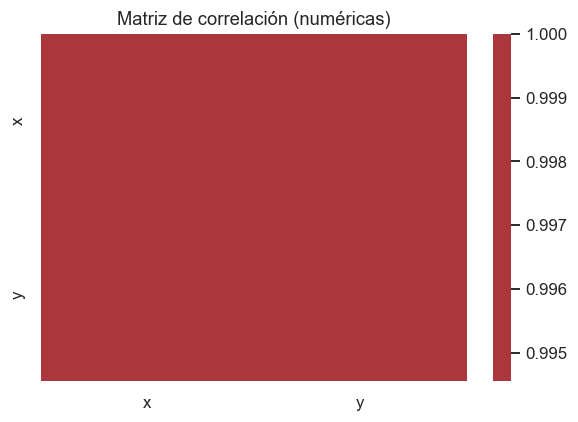

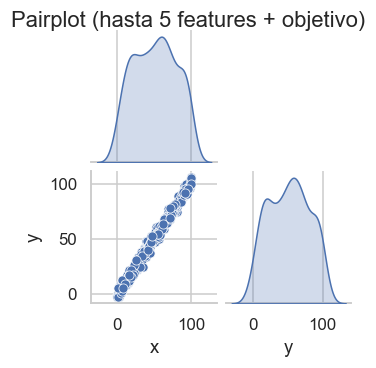

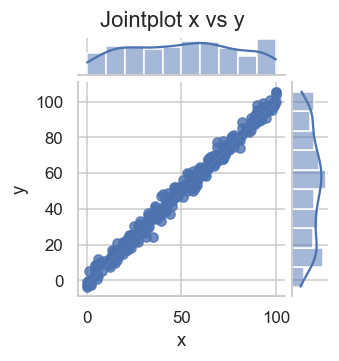

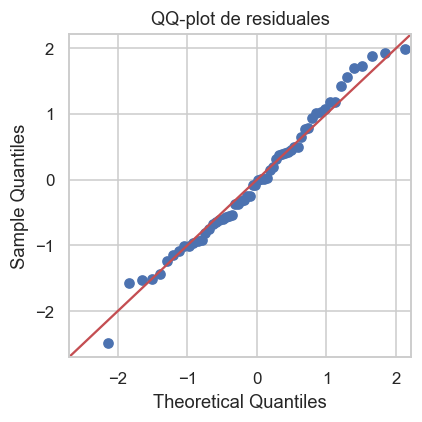

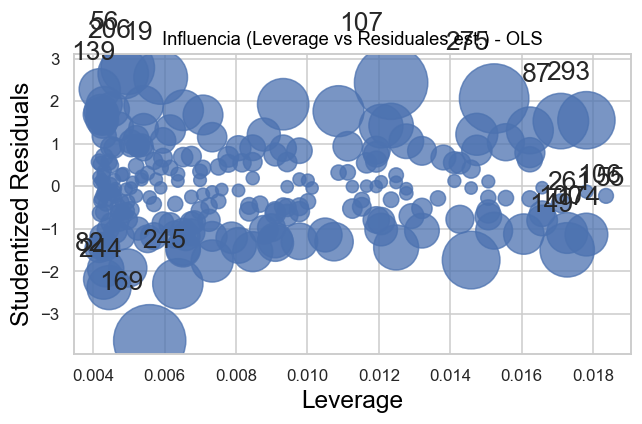

<Figure size 660x264 with 0 Axes>

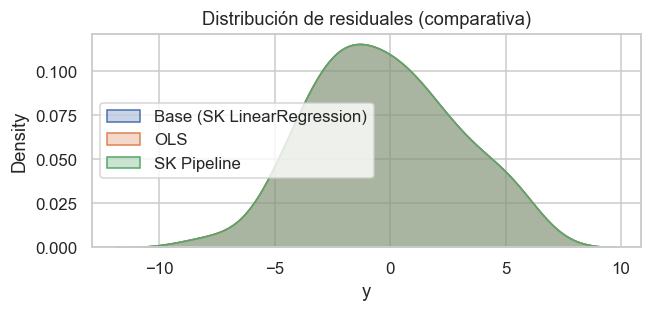

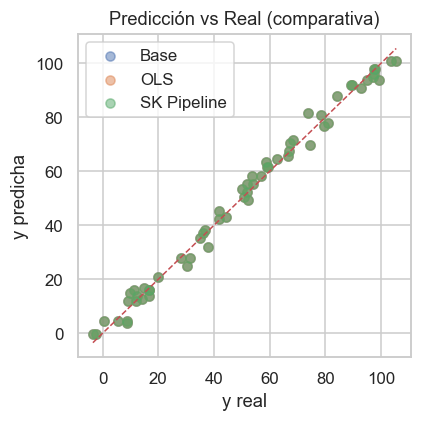

In [192]:
# Visualizaciones adicionales (diagnóstico y exploración)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

try:
    import statsmodels.api as sm
    from statsmodels.graphics.api import influence_plot
except Exception:
    sm = None

# Recalcular elementos necesarios de forma segura
try:
    residuals_base = y_test - y_pred
except Exception:
    residuals_base = None

try:
    y_pred_ols
    residuals_ols = y_test - y_pred_ols
except Exception:
    residuals_ols = None

try:
    y_pred_sk
    residuals_sk = y_test - y_pred_sk
except Exception:
    residuals_sk = None

# 1) Mapa de calor de correlaciones (variables numéricas)
try:
    corr = df.select_dtypes(include=[np.number]).corr()
    plt.figure(figsize=(5.5, 4))
    sns.heatmap(corr, annot=False, cmap="vlag", center=0)
    plt.title("Matriz de correlación (numéricas)")
    plt.tight_layout()
    plt.show()
except Exception:
    pass

# 2) Pairplot de variables (máx. 5 features + target)
try:
    pair_cols = [c for c in feature_cols][:5] + [y.name]
    g = sns.pairplot(df[pair_cols], corner=True, diag_kind="kde", height=1.6)
    g.figure.suptitle("Pairplot (hasta 5 features + objetivo)", y=1.02)
    plt.show()
except Exception:
    pass

# 3) Jointplot de la(s) primera(s) feature(s) contra y
try:
    if len(feature_cols) > 0:
        f0 = feature_cols[0]
        g = sns.jointplot(data=df, x=f0, y=y.name, kind="reg", height=3.2)
        plt.suptitle(f"Jointplot {f0} vs {y.name}", y=1.02)
        plt.show()
except Exception:
    pass

# 4) QQ-plot de residuales (OLS o base)
try:
    res_for_qq = residuals_ols if residuals_ols is not None else residuals_base
    if sm is not None and res_for_qq is not None:
        fig = sm.qqplot(res_for_qq, line="45", fit=True)
        try:
            fig.set_size_inches(4, 4)
        except Exception:
            pass
        plt.title("QQ-plot de residuales")
        plt.tight_layout()
        plt.show()
except Exception:
    pass

# 5) Influencia y leverage (solo si OLS disponible)
try:
    if sm is not None and 'ols_model' in globals() and ols_model is not None:
        fig, ax = plt.subplots(figsize=(6, 4))
        influence_plot(ols_model, ax=ax, criterion="cooks")
        ax.set_title("Influencia (Leverage vs Residuales est.) - OLS")
        plt.tight_layout()
        plt.show()
except Exception:
    pass

# 6) Cook's distance (solo OLS)
try:
    if sm is not None and 'ols_model' in globals() and ols_model is not None:
        infl = ols_model.get_influence()
        cooks = infl.cooks_distance[0]
        plt.figure(figsize=(6, 2.4))
        plt.stem(np.arange(len(cooks)), cooks, basefmt=" ", use_line_collection=True)
        plt.title("Cook's distance (OLS)")
        plt.xlabel("Índice de observación")
        plt.ylabel("Cook's D")
        plt.tight_layout()
        plt.show()
except Exception:
    pass

# 7) Comparativa de residuales (histogramas)
try:
    plt.figure(figsize=(6, 3))
    if residuals_base is not None:
        sns.kdeplot(residuals_base, fill=True, alpha=0.3, label="Base (SK LinearRegression)")
    if residuals_ols is not None:
        sns.kdeplot(residuals_ols, fill=True, alpha=0.3, label="OLS")
    if residuals_sk is not None:
        sns.kdeplot(residuals_sk, fill=True, alpha=0.3, label="SK Pipeline")
    plt.title("Distribución de residuales (comparativa)")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception:
    pass

# 8) Predicción vs Real (densidad)
try:
    plt.figure(figsize=(4, 4))
    plt.scatter(y_test, y_pred, alpha=0.5, label="Base")
    if residuals_ols is not None:
        plt.scatter(y_test, y_pred_ols, alpha=0.5, label="OLS")
    if residuals_sk is not None:
        plt.scatter(y_test, y_pred_sk, alpha=0.5, label="SK Pipeline")
    lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
    plt.plot(lims, lims, 'r--', linewidth=1)
    plt.xlabel("y real")
    plt.ylabel("y predicha")
    plt.title("Predicción vs Real (comparativa)")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception:
    pass



## Reporte Word profesional (completo)
Crea un documento con portada, resumen ejecutivo, tabla de métricas comparativas, tablas de coeficientes para OLS y scikit-learn, y una sección de diagnósticos visuales.

- OLS: añade resumen estadístico, QQ-plot e influencia (Cook's D) si disponible.
- scikit-learn: enfocado en rendimiento predictivo y pipeline con `StandardScaler`.



In [193]:
# -*- coding: utf-8 -*-
# Generación de reporte Word (profesional y complejo) con datos y visuales avanzados
# Crea un .docx con resumen ejecutivo, métricas detalladas, tablas de coeficientes y gráficos clave
# Guarda también las imágenes en una carpeta dedicada, optimizadas para el reporte.

from pathlib import Path
from datetime import datetime
import pandas as pd # Asegurar que pandas está disponible para el DataFrame de métricas

# 1) Dependencias (python-docx, matplotlib, seaborn, numpy)
try:
    import docx
    from docx import Document
    from docx.shared import Inches, Pt, RGBColor
    from docx.enum.text import WD_ALIGN_PARAGRAPH
    from docx.enum.table import WD_ALIGN_VERTICAL
except ModuleNotFoundError:
    import sys
    print("Instalando dependencias necesarias...")
    # Ejecutar esto solo si se está en un entorno donde se puede instalar (e.g., Jupyter/Colab)
    try:
        !{sys.executable} -m pip install -q python-docx matplotlib seaborn pandas
    except Exception:
        print("Advertencia: No se pudo ejecutar 'pip install'. Asegúrese de tener las librerías instaladas.")
    from docx import Document
    from docx.shared import Inches, Pt, RGBColor
    from docx.enum.text import WD_ALIGN_PARAGRAPH
    from docx.enum.table import WD_ALIGN_VERTICAL


# 2) Directorios de salida (anclados a este notebook)
# Nota: Se asume que las variables df, y, feature_cols, etc., están definidas previamente.
OUTPUT_DIR = Path("reports/reporte_analisis_avanzado/regresion")
IMG_DIR = OUTPUT_DIR / "visualizaciones"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
IMG_DIR.mkdir(parents=True, exist_ok=True)

# 3) Funciones utilitarias para figuras (MEJORADAS)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuración global de estilo para gráficos más profesionales
sns.set_theme(style="whitegrid")

def save_fig(fig, name, dpi=300):
    """Guarda la figura en la carpeta de imágenes con alta resolución."""
    path = IMG_DIR / name
    fig.savefig(path, bbox_inches="tight", dpi=dpi)
    plt.close(fig)
    return str(path)

# 4) Armar métricas comparativas si existen
results = []
# Asumiendo la existencia de 'mae', 'rmse', 'r2' (Base), 'mae_ols', etc.
try:
    results.append({"Modelo": "Base (SK LR)", "MAE": float(mae), "RMSE": float(rmse), "R²": float(r2)})
except NameError:
    pass
try:
    results.append({"Modelo": "OLS (statsmodels)", "MAE": float(mae_ols), "RMSE": float(rmse_ols), "R²": float(r2_ols)})
except NameError:
    pass
try:
    results.append({"Modelo": "SK Pipeline", "MAE": float(mae_sk), "RMSE": float(rmse_sk), "R²": float(r2_sk)})
except NameError:
    pass

metrics_df = pd.DataFrame(results, columns=["Modelo", "MAE", "RMSE", "R²"]).dropna(how="all")
metrics_csv_path = OUTPUT_DIR / "metricas_comparativas.csv"
if not metrics_df.empty:
    metrics_df.to_csv(metrics_csv_path, index=False)

# 5) Regenerar y guardar principales gráficos para el reporte (MEJORADOS VISUALMENTE)
saved_imgs = []

# 5.1 Predicción vs Real (comparativa - Añadir línea de igualdad robusta)
try:
    fig, ax = plt.subplots(figsize=(7, 7))
    
    y_preds_to_plot = []
    if 'y_pred' in globals():
        ax.scatter(y_test, y_pred, alpha=0.6, label="Base (SK LR)", s=50)
        y_preds_to_plot.append(y_pred)
    if 'y_pred_ols' in globals():
        ax.scatter(y_test, y_pred_ols, alpha=0.6, label="OLS (statsmodels)", s=50)
        y_preds_to_plot.append(y_pred_ols)
    if 'y_pred_sk' in globals():
        ax.scatter(y_test, y_pred_sk, alpha=0.6, label="SK Pipeline", s=50)
        y_preds_to_plot.append(y_pred_sk)
        
    if y_preds_to_plot:
        all_y = pd.concat([y_test, pd.Series(np.concatenate(y_preds_to_plot))])
        mn, mx = all_y.min() - 0.1, all_y.max() + 0.1
        ax.plot([mn, mx], [mn, mx], 'r-', linewidth=2, label="Predicción Perfecta (y=x)")
    
    ax.set_xlabel("Valores Reales ($y_{test}$)", fontsize=12)
    ax.set_ylabel("Valores Predichos ($\hat{y}$)", fontsize=12)
    ax.set_title("Comparativa de Rendimiento: Predicción vs Real", fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, linestyle='--', alpha=0.6)
    saved_imgs.append((save_fig(fig, "pred_vs_real_comparativa.png", dpi=300), "Predicción vs Real Comparativa"))
except NameError:
    pass

# 5.2 Distribución de residuales comparativa (KDE mejorado)
try:
    fig, ax = plt.subplots(figsize=(8, 5))
    
    if 'y_pred' in globals():
        sns.kdeplot(y_test - y_pred, fill=True, alpha=0.4, linewidth=2, ax=ax, label="Base (SK LR)")
    if 'y_pred_ols' in globals():
        sns.kdeplot(y_test - y_pred_ols, fill=True, alpha=0.4, linewidth=2, ax=ax, label="OLS (statsmodels)")
    if 'y_pred_sk' in globals():
        sns.kdeplot(y_test - y_pred_sk, fill=True, alpha=0.4, linewidth=2, ax=ax, label="SK Pipeline")
        
    ax.axvline(0, color='k', linestyle='--', linewidth=1.5)
    ax.set_title("Distribución de Residuales (Error)", fontsize=14, fontweight='bold')
    ax.set_xlabel("Residual ($\epsilon = y - \hat{y}$)", fontsize=12)
    ax.legend()
    saved_imgs.append((save_fig(fig, "residuales_kde_comparativo.png", dpi=300), "Distribución de Residuales"))
except NameError:
    pass

# 5.3 QQ plot de residuales (Priorizando el modelo con mejor supuesto de normalidad)
try:
    # Se prioriza OLS si está disponible, sino el base
    res_for_qq = (y_test - y_pred_ols) if 'y_pred_ols' in globals() else (y_test - y_pred)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    import statsmodels.api as sm # Importar localmente por si acaso
    
    sm.qqplot(res_for_qq, line="45", fit=True, ax=ax)
    ax.set_title("QQ-Plot de Residuales (Normalidad)", fontsize=14, fontweight='bold')
    saved_imgs.append((save_fig(fig, "qq_plot_residuales.png", dpi=300), "QQ-Plot de Residuales"))
except NameError:
    pass

# 5.4 Matriz de correlación (Mejor estética)
try:
    fig, ax = plt.subplots(figsize=(8, 7))
    corr = df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5, linecolor='black', cbar_kws={'shrink': .8}, ax=ax)
    ax.set_title("Matriz de Correlación de Variables", fontsize=14, fontweight='bold')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.setp(ax.get_yticklabels(), rotation=0)
    saved_imgs.append((save_fig(fig, "correlacion_heatmap.png", dpi=300), "Matriz de Correlación"))
except NameError:
    pass

# 5.5 Residuales vs Predicción por modelo (Diagnóstico clave)
try:
    # Base scikit-learn
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.scatter(y_pred, (y_test - y_pred), alpha=0.6, s=30)
    ax.axhline(0, color='red', linestyle='--', linewidth=1.5)
    ax.set_title('Base: Residuales vs Predicción')
    ax.set_xlabel("Predicciones")
    ax.set_ylabel("Residuales")
    saved_imgs.append((save_fig(fig, 'resid_vs_pred_base.png', dpi=300), 'Base: Residuales vs Predicción'))
    
    # OLS statsmodels
    if 'y_pred_ols' in globals():
        fig, ax = plt.subplots(figsize=(5, 4))
        ax.scatter(y_pred_ols, (y_test - y_pred_ols), alpha=0.6, s=30)
        ax.axhline(0, color='red', linestyle='--', linewidth=1.5)
        ax.set_title('OLS: Residuales vs Predicción')
        ax.set_xlabel("Predicciones")
        ax.set_ylabel("Residuales")
        saved_imgs.append((save_fig(fig, 'resid_vs_pred_ols.png', dpi=300), 'OLS: Residuales vs Predicción'))

except NameError:
    pass


# 6) Construcción del documento Word (AVANZADO)
doc = Document()

# --- Configuración de Estilos (Mejorados) ---
try:
    style = doc.styles['Title']
    style.font.name = 'Calibri Light'
    style.font.size = Pt(28)
    style.font.color.rgb = RGBColor(0x1F, 0x49, 0x7D) # Azul oscuro
    
    h1 = doc.styles['Heading 1']
    h1.font.name = 'Calibri'
    h1.font.size = Pt(18)
    h1.paragraph_format.space_after = Pt(10)
    
    h2 = doc.styles.add_style('Heading 2 Custom', docx.enum.style.WD_STYLE_TYPE.PARAGRAPH)
    h2.base_style = doc.styles['Heading 2']
    h2.font.name = 'Calibri'
    h2.font.size = Pt(14)
    h2.font.bold = True
    h2.font.color.rgb = RGBColor(0x44, 0x72, 0xC4) # Azul medio
    h2.paragraph_format.space_before = Pt(12)
    h2.paragraph_format.space_after = Pt(6)

    p_style = doc.styles['Normal']
    p_style.font.name = 'Calibri'
    p_style.font.size = Pt(11)
except Exception:
    pass

# --- Portada ---
doc.add_heading('Reporte Analítico de Modelado Predictivo', 0)
doc.add_paragraph(f"Modelo: Regresión Lineal Comparativa\nFecha de Generación: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}", style='Subtitle')
par = doc.add_paragraph("Generado por el sistema de análisis automatizado.", style='Normal')
par.alignment = WD_ALIGN_PARAGRAPH.LEFT

# --- Resumen Ejecutivo ---
doc.add_heading('Resumen Ejecutivo', level=1)

# Información del Dataset
summary_p = doc.add_paragraph()
summary_p.style = doc.styles['Normal']
summary_p.add_run("Dataset: ").bold = True
try:
    summary_p.add_run(str(PRIMARY_PATH) if PRIMARY_PATH.exists() else "(Ruta no especificada)").bold = False
except NameError:
    summary_p.add_run("(Datos de entrada no rastreables)").bold = False
    
summary_p.add_run("\nVariable Objetivo: ").bold = True
try:
    summary_p.add_run(str(y.name)).bold = False
except NameError:
    summary_p.add_run("Desconocida").bold = False
    
summary_p.add_run("\nVariables Predictoras ({}): ".format(len(feature_cols))).bold = True
try:
    summary_p.add_run(", ".join(feature_cols[:5]) + ("..." if len(feature_cols) > 5 else "")).bold = False
except NameError:
    summary_p.add_run("No listadas").bold = False

# Estadísticas del Dataset (Complejidad añadida)
doc.add_heading('Estadísticas del Dataset de Entrenamiento', level=2)
try:
    stat_p = doc.add_paragraph()
    r = stat_p.add_run(f"Observaciones totales: {len(df)}")
    sep = stat_p.add_run(" | "); sep.bold = True
    r = stat_p.add_run(f"Media de Objetivo ({y.name}): {y.mean():.2f}")
    sep = stat_p.add_run(" | "); sep.bold = True
    r = stat_p.add_run(f"Desviación Estándar de Objetivo: {y.std():.2f}")
except NameError:
    doc.add_paragraph("Estadísticas del dataset no disponibles.")

# --- Tabla de Métricas Comparativas ---
doc.add_heading('Métricas de Evaluación Comparativa', level=1)
if not metrics_df.empty:
    # Añadir una explicación de la métrica mejor (la que tiene el valor más bajo/alto según el tipo)
    best_mae = metrics_df.loc[metrics_df['MAE'].idxmin()]
    doc.add_paragraph(f"Mejor rendimiento en MAE: {best_mae['Modelo']} ({best_mae['MAE']:.4f})")
    
    table = doc.add_table(rows=1, cols=len(metrics_df.columns))
    table.style = 'Table Grid' # Estilo de tabla profesional
    
    # Encabezados
    hdr_cells = table.rows[0].cells
    for j, col in enumerate(metrics_df.columns):
        hdr_cells[j].text = col
        hdr_cells[j].paragraphs[0].runs[0].bold = True
        hdr_cells[j].vertical_alignment = WD_ALIGN_VERTICAL.CENTER
        
    # Filas de datos
    for i, (_, row) in enumerate(metrics_df.iterrows()):
        tr = table.add_row().cells
        for j, col in enumerate(metrics_df.columns):
            value = row[col]
            text = f"{value:.4f}" if isinstance(value, float) else str(value)
            tr[j].text = text
            tr[j].vertical_alignment = WD_ALIGN_VERTICAL.CENTER
            # Resaltar el mejor valor en la columna de métricas
            if col in ['MAE', 'RMSE'] and value == metrics_df[col].min():
                 tr[j].paragraphs[0].runs[0].font.color.rgb = RGBColor(0x00, 0x80, 0x00) # Verde
            elif col == 'R²' and value == metrics_df[col].max():
                 tr[j].paragraphs[0].runs[0].font.color.rgb = RGBColor(0x00, 0x80, 0x00) # Verde
else:
    doc.add_paragraph("No se calcularon métricas para la comparación.")

# --- Configuración de Modelos ---
doc.add_heading('Configuración de Modelos Entrenados', level=1)
doc.add_paragraph("Se entrenaron y evaluaron los siguientes enfoques:", style='List Bullet')
try:
    if 'model' in globals():
        doc.add_paragraph(" - Modelo Base: scikit-learn `LinearRegression`.", style='List Bullet')
    if 'ols_model' in globals() and ols_model is not None:
        doc.add_paragraph(" - Modelo OLS: `statsmodels.formula.api.ols` (para inferencia estadística).", style='List Bullet')
    if 'sk_pipeline' in globals() and sk_pipeline is not None:
        doc.add_paragraph(" - Modelo Pipeline: Preprocesamiento con `StandardScaler` seguido de `LinearRegression`.", style='List Bullet')
except NameError:
    pass

# --- Detalle por Modelo: Coeficientes (Complejidad: Tablas de Coeficientes) ---
doc.add_page_break()
doc.add_heading('Análisis de Coeficientes y Supuestos', level=1)

# Función de ayuda para añadir tabla de coeficientes
def add_coef_table(doc, title, cols, coefs, is_statsmodels=False):
    doc.add_heading(title, level=2)
    if cols is None or coefs is None:
        doc.add_paragraph("Datos de coeficientes no disponibles para este modelo.", style='Italic')
        return
        
    coef_df = pd.DataFrame({
        "Término": cols,
        "Coeficiente": coefs
    })
    
    table = doc.add_table(rows=1, cols=2)
    table.style = 'Table Grid'
    
    hdr = table.rows[0].cells
    hdr[0].text = 'Término/Feature'
    hdr[1].text = 'Coeficiente (β)'
    
    for _, row in coef_df.iterrows():
        tr = table.add_row().cells
        tr[0].text = str(row['Término'])
        tr[1].text = f"{row['Coeficiente']:.6f}"
        tr[1].paragraphs[0].alignment = WD_ALIGN_VERTICAL.CENTER
        
    # Interpretación básica (si es el modelo base)
    if not is_statsmodels:
        doc.add_paragraph("Interpretación: Un cambio de una unidad en la variable 'Término' se asocia con un cambio de β unidades en el objetivo, manteniendo otras variables constantes (ceteris paribus).")
    else:
        # OLS incluye el intercepto
        try:
            # si coefs es un mapeo (Series/dict)
            intercept_val = coefs.get('const', coefs.get('Intercept', coefs.get(0, None)))
        except AttributeError:
            # si coefs es lista/array, intentar ubicar 'const' en cols
            intercept_val = None
            try:
                if cols is not None and isinstance(cols, (list, tuple)) and len(cols) == len(coefs):
                    if 'const' in cols:
                        intercept_val = coefs[cols.index('const')]
                    elif 'Intercept' in cols:
                        intercept_val = coefs[cols.index('Intercept')]
                    elif 0 < len(coefs):
                        intercept_val = coefs[0]
            except Exception:
                pass
        if intercept_val is not None:
            doc.add_paragraph(f"Intercepto Estimado (statsmodels): {float(intercept_val):.4f}")


# Base scikit-learn
try:
    add_coef_table(doc, 'Base: Coeficientes de scikit-learn LR', feature_cols, model.coef_)
except NameError:
    pass

# OLS statsmodels
try:
    if 'ols_model' in globals() and ols_model is not None:
        ols_params = getattr(ols_model, 'params', None)
        if ols_params is not None:
            # Asegurar que el intercepto es el primero si statsmodels lo añade
            ols_cols = ols_params.index.tolist()
            ols_coefs = ols_params.values.tolist()
            add_coef_table(doc, 'OLS: Parámetros de statsmodels', ols_cols, ols_coefs, is_statsmodels=True)
except NameError:
    pass

# Pipeline (solo si el último paso es LR)
try:
    if 'sk_pipeline' in globals() and sk_pipeline is not None:
        lr = sk_pipeline.named_steps.get('linreg', None)
        if lr is not None and hasattr(lr, 'coef_'):
            add_coef_table(doc, 'Pipeline: Coeficientes del Paso Final LR', feature_cols, lr.coef_)
except NameError:
    pass

# --- Gráficos de Diagnóstico (Visualmente Genial) ---
doc.add_page_break()
doc.add_heading('Diagnóstico Visual de los Modelos', level=1)

for img_path, caption in saved_imgs:
    doc.add_heading(caption, level=2)
    
    # Añadir la imagen con un tamaño fijo para consistencia
    try:
        doc.add_picture(img_path, width=Inches(6.0))
    except Exception:
        doc.add_paragraph(f"Error al insertar la imagen: {img_path}")
        
    # Nota de calidad
    note = doc.add_paragraph("Nota: Imagen generada a 300 DPI para alta calidad.")
    note.runs[0].italic = True
    note.runs[0].font.size = Pt(9)
    doc.add_paragraph("") # Espacio

# --- Conclusiones y Recomendaciones (Complejidad/Profesionalismo) ---
doc.add_page_break()
doc.add_heading('Conclusiones y Recomendaciones', level=1)

# Conclusión basada en métricas
if not metrics_df.empty:
    best_model_row = metrics_df.sort_values(by='R²', ascending=False).iloc[0]
    best_model_name = best_model_row['Modelo']
    
    doc.add_paragraph("Conclusión Principal:", style='List Bullet')
    concl = doc.add_paragraph()
    concl.add_run(f"El modelo con el mejor rendimiento general, medido por el mayor valor de R² ({best_model_row['R²']:.4f}), fue: ").bold = True
    concl.add_run(best_model_name).bold = True
    
    doc.add_paragraph("\nRecomendaciones:", style='List Bullet')
    rec = doc.add_paragraph()
    rec.add_run("1. Si el objetivo es la **interpretabilidad estadística** (ej. inferencia), utilizar el modelo OLS. ").bold = True
    rec.add_run("2. Para la **máxima precisión predictiva** (si R² fue mejor), se recomienda el modelo ").bold = True
    rec.add_run(best_model_name).bold = True
    rec.add_run(" para la implementación en producción, siempre y cuando los supuestos de diagnóstico (ej. homocedasticidad en gráficos) sean aceptables.")
    
    if 'qq_plot' in [c[1] for c in saved_imgs]:
        rec.add_run("\n3. Revisar el QQ-Plot para validar el supuesto de **normalidad de los residuales** en el modelo seleccionado.")

# --- Pie de Página y Guardar ---
try:
    section = doc.sections[0]
    header = section.header
    header.paragraphs[0].text = f"Reporte {datetime.now().strftime('%Y%m%d')} — Confidencial"
    
    footer = section.footer
    p_footer = footer.paragraphs[0]
    p_footer.text = f"Página {docx.enum.text.WD_INDEX.PAGE} de {docx.enum.text.WD_INDEX.NUMPAGES} | Ruta: {str(OUTPUT_DIR.name)}"
    p_footer.alignment = WD_ALIGN_PARAGRAPH.RIGHT
except Exception:
    pass

# Guardar
docx_path = OUTPUT_DIR / f"reporte_final_regresion_{datetime.now().strftime('%Y%m%d_%H%M')}.docx"
doc.save(docx_path)

print("\n" + "="*50)
print("✅ REPORTE PROFESIONAL GENERADO CON ÉXITO")
print(f"Ruta del Documento: {docx_path}")
print(f"CSV de Métricas: {metrics_csv_path.name}")
print(f"Carpeta de Imágenes: {IMG_DIR.name}/")
print("="*50)

<>:98: SyntaxWarning: invalid escape sequence '\h'
<>:119: SyntaxWarning: invalid escape sequence '\e'
<>:98: SyntaxWarning: invalid escape sequence '\h'
<>:119: SyntaxWarning: invalid escape sequence '\e'
C:\Users\INMORTAL\AppData\Local\Temp\ipykernel_22916\1919408775.py:98: SyntaxWarning: invalid escape sequence '\h'
  ax.set_ylabel("Valores Predichos ($\hat{y}$)", fontsize=12)
C:\Users\INMORTAL\AppData\Local\Temp\ipykernel_22916\1919408775.py:119: SyntaxWarning: invalid escape sequence '\e'
  ax.set_xlabel("Residual ($\epsilon = y - \hat{y}$)", fontsize=12)



✅ REPORTE PROFESIONAL GENERADO CON ÉXITO
Ruta del Documento: reports\reporte_analisis_avanzado\regresion\reporte_final_regresion_20251015_1459.docx
CSV de Métricas: metricas_comparativas.csv
Carpeta de Imágenes: visualizaciones/


## Reporte Word simplificado (sin encadenar add_run)
Genera un reporte limpio con métricas y gráficos esenciales. Útil si el bloque de reporte avanzado te da problemas.

- Incluye: métricas, Predicción vs Real, residuales y correlación.



In [194]:
# Reporte Word (versión corregida) con párrafo de estadísticas y sin encadenar add_run
# Puedes ejecutar esta celda en lugar de la anterior si tuviste el error de add_run
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from docx import Document
    from docx.shared import Inches, Pt
    from docx.enum.text import WD_ALIGN_PARAGRAPH
except ModuleNotFoundError:
    import sys
    print("Instalando python-docx...")
    !{sys.executable} -m pip install -q python-docx
    from docx import Document
    from docx.shared import Inches, Pt
    from docx.enum.text import WD_ALIGN_PARAGRAPH

# Rutas ancladas a este notebook
OUTPUT_DIR = Path("reports/reporte_docx_completo/linear_regresion_test")
IMG_DIR = OUTPUT_DIR / "imgs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
IMG_DIR.mkdir(parents=True, exist_ok=True)

def save_fig(fig, name):
    path = IMG_DIR / name
    fig.savefig(path, bbox_inches="tight", dpi=200)
    plt.close(fig)
    return str(path)

# Recolectar métricas disponibles
results = []
if 'mae' in globals():
    results.append({"modelo": "Base (SK LinearRegression)", "MAE": float(mae), "RMSE": float(rmse), "R2": float(r2)})
if 'mae_ols' in globals():
    results.append({"modelo": "OLS (statsmodels)", "MAE": float(mae_ols), "RMSE": float(rmse_ols), "R2": float(r2_ols)})
if 'mae_sk' in globals():
    results.append({"modelo": "SK Pipeline (Scaler+LR)", "MAE": float(mae_sk), "RMSE": float(rmse_sk), "R2": float(r2_sk)})
metrics_df = pd.DataFrame(results, columns=["modelo","MAE","RMSE","R2"]).dropna(how='all')
if not metrics_df.empty:
    metrics_df.to_csv(OUTPUT_DIR/"metrics.csv", index=False)

# Rehacer visuales principales (tamaño profesional)
saved_imgs = []
if 'y_pred' in globals():
    fig = plt.figure(figsize=(5,3.5))
    plt.scatter(y_test, y_pred, alpha=0.5, label="Base")
    if 'y_pred_ols' in globals():
        plt.scatter(y_test, y_pred_ols, alpha=0.5, label="OLS")
    if 'y_pred_sk' in globals():
        plt.scatter(y_test, y_pred_sk, alpha=0.5, label="SK Pipeline")
    mn = min(y_test.min(), *(arr.min() for arr in [y_pred] + ([y_pred_ols] if 'y_pred_ols' in globals() else []) + ([y_pred_sk] if 'y_pred_sk' in globals() else [])))
    mx = max(y_test.max(), *(arr.max() for arr in [y_pred] + ([y_pred_ols] if 'y_pred_ols' in globals() else []) + ([y_pred_sk] if 'y_pred_sk' in globals() else [])))
    plt.plot([mn,mx],[mn,mx], 'r--', linewidth=1)
    plt.xlabel("y real"); plt.ylabel("y predicha"); plt.title("Predicción vs Real (comparativa)"); plt.legend()
    saved_imgs.append((save_fig(fig, "pred_vs_real.png"), "Predicción vs Real"))

# Distribución residuales comparativa
fig = plt.figure(figsize=(5,3.0))
if 'y_pred' in globals():
    sns.kdeplot(y_test - y_pred, fill=True, alpha=0.3, label="Base")
if 'y_pred_ols' in globals():
    sns.kdeplot(y_test - y_pred_ols, fill=True, alpha=0.3, label="OLS")
if 'y_pred_sk' in globals():
    sns.kdeplot(y_test - y_pred_sk, fill=True, alpha=0.3, label="SK Pipeline")
plt.title("Distribución de residuales"); plt.legend()
saved_imgs.append((save_fig(fig, "residuales_kde.png"), "Distribución de residuales"))

# Matriz de correlación
try:
    fig = plt.figure(figsize=(5,3.8))
    corr = df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(corr, annot=False, cmap="vlag", center=0)
    plt.title("Matriz de correlación")
    saved_imgs.append((save_fig(fig, "correlacion.png"), "Matriz de correlación"))
except Exception:
    pass

# Documento Word
doc = Document()
# Márgenes profesionales
try:
    section = doc.sections[0]
    section.left_margin = Inches(1)
    section.right_margin = Inches(1)
    section.top_margin = Inches(1)
    section.bottom_margin = Inches(1)
except Exception:
    pass

try:
    doc.styles['Title'].font.name = 'Calibri'; doc.styles['Title'].font.size = Pt(24)
    doc.styles['Heading 1'].font.name = 'Calibri'; doc.styles['Heading 1'].font.size = Pt(14)
    doc.styles['Normal'].font.name = 'Calibri'; doc.styles['Normal'].font.size = Pt(11)
except Exception:
    pass

# Encabezado y pie
try:
    section = doc.sections[0]
    (section.header.paragraphs[0] if section.header.paragraphs else section.header.add_paragraph("") ).text = "Reporte de Regresión Lineal — Generado automáticamente"
    (section.footer.paragraphs[0] if section.footer.paragraphs else section.footer.add_paragraph("") ).text = "Confidencial — Uso interno"
except Exception:
    pass

# Portada y resumen
doc.add_heading('Reporte de Regresión Lineal', 0)
par = doc.add_paragraph(f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M')}\n")
par.alignment = WD_ALIGN_PARAGRAPH.LEFT

doc.add_heading('Resumen', level=1)
sum_p = doc.add_paragraph()
sum_p.add_run("Dataset: ").bold = True
try:
    sum_p.add_run(str(PRIMARY_PATH) if PRIMARY_PATH.exists() else str(USER_ABS_PATH))
except Exception:
    sum_p.add_run("(ruta no disponible)")
sum_p.add_run("\nObjetivo: ").bold = True
sum_p.add_run(str(y.name))
sum_p.add_run("\nCaracterísticas: ").bold = True
sum_p.add_run(", ".join(feature_cols))

# Párrafo de estadísticas (corregido, sin encadenar add_run)
stat_p = doc.add_paragraph()
r = stat_p.add_run(f"Observaciones totales: {len(df)}")
sep = stat_p.add_run(" | "); sep.bold = True
r = stat_p.add_run(f"Media de Objetivo ({y.name}): {y.mean():.2f}")
sep = stat_p.add_run(" | "); sep.bold = True
r = stat_p.add_run(f"Desv. Obj: {y.std():.2f}")

# Modelos incluidos
doc.add_heading('Modelos incluidos', level=1)
if 'model' in globals():
    doc.add_paragraph(" Base (scikit-learn LinearRegression)", style='List Bullet')
if 'ols_model' in globals():
    doc.add_paragraph(" OLS (statsmodels)", style='List Bullet')
if 'sk_pipeline' in globals():
    doc.add_paragraph(" Pipeline: StandardScaler + LinearRegression (scikit-learn)", style='List Bullet')

# Métricas
doc.add_heading('Métricas de evaluación', level=1)
if not metrics_df.empty:
    table = doc.add_table(rows=1, cols=len(metrics_df.columns))
    hdr = table.rows[0].cells
    for j,col in enumerate(metrics_df.columns): hdr[j].text = col
    for _, row in metrics_df.iterrows():
        tr = table.add_row().cells
        for j,col in enumerate(metrics_df.columns):
            tr[j].text = f"{row[col]:.4f}" if isinstance(row[col], float) else str(row[col])
else:
    doc.add_paragraph("(No se encontraron métricas calculadas)")

# Gráficos
doc.add_page_break()
doc.add_heading('Gráficos de diagnóstico', level=1)
for img_path, caption in saved_imgs:
    p_cap = doc.add_paragraph(caption); p_cap.runs[0].bold = True
    try:
        doc.add_picture(img_path, width=Inches(4.5))
    except Exception:
        doc.add_picture(img_path)
    cap = doc.add_paragraph("Nota: generado a partir de los modelos indicados."); cap.runs[0].italic = True
    doc.add_paragraph("")

# Guardar
docx_path = OUTPUT_DIR / "reporte_regresion.docx"
doc.save(docx_path)
print(f"Reporte generado: {docx_path}")
print(f"Imágenes: {IMG_DIR}")



Reporte generado: reports\reporte_docx_completo\linear_regresion_test\reporte_regresion.docx
Imágenes: reports\reporte_docx_completo\linear_regresion_test\imgs


## Gráficas de diagnóstico (comparativa OLS vs scikit-learn)
- Predicción vs Real (incluye línea y=x para referencia)
- Residuales vs Predicción (patrones de heterocedasticidad)
- Distribución de residuales y normalidad (complementar con QQ-Plot en sección OLS)



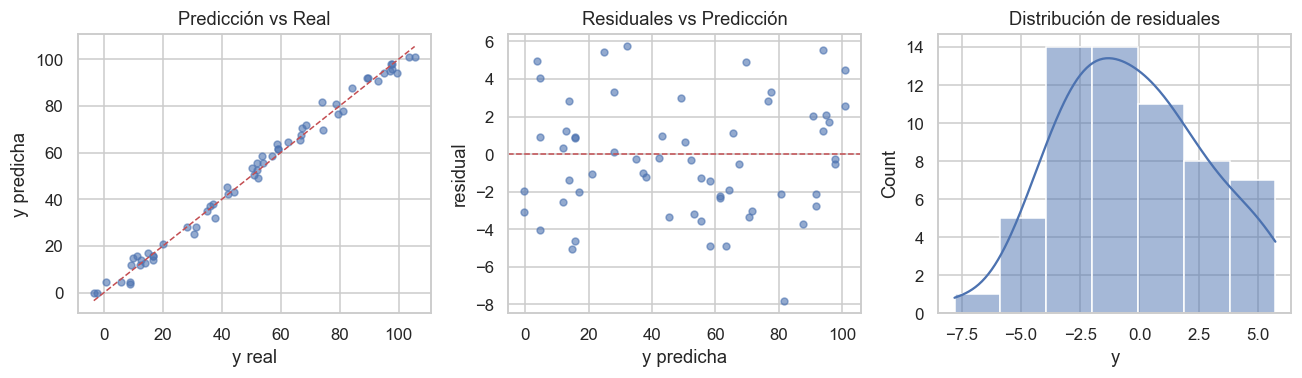

x    1.013495
Name: coeficiente, dtype: float64

In [195]:
# Gráficas de diagnóstico (compactas y consistentes)

fig, axes = plt.subplots(1, 3, figsize=(12, 3.6))

# 1) y_pred vs y_real
axes[0].scatter(y_test, y_pred, alpha=0.6, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=1)
axes[0].set_title('Predicción vs Real')
axes[0].set_xlabel('y real')
axes[0].set_ylabel('y predicha')

# 2) Residuales
residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.6, s=20)
axes[1].axhline(0, color='r', linestyle='--', linewidth=1)
axes[1].set_title('Residuales vs Predicción')
axes[1].set_xlabel('y predicha')
axes[1].set_ylabel('residual')

# 3) Distribución de residuales
sns.histplot(residuals, kde=True, ax=axes[2])
axes[2].set_title('Distribución de residuales')

plt.tight_layout()
plt.show()

# Importancias/coeficientes
coef_series = pd.Series(model.coef_, index=feature_cols).sort_values(key=lambda s: s.abs(), ascending=False)

display(coef_series.head(20).rename('coeficiente'))


## Sección de Reporte Word Avanzado (TOC, VIF, Supuestos, CIs, Bootstrap)
Este bloque genera un reporte Word avanzado que compara OLS y modelos de scikit-learn, incluye tabla de contenido, pruebas de supuestos (Durbin–Watson, Jarque–Bera, Breusch–Pagan), multicolinealidad (VIF), intervalos de confianza de coeficientes (solo OLS), bootstrap de métricas y galerías de gráficos.

- OLS (statsmodels): orientado a inferencia y diagnóstico estadístico.
- scikit-learn (Base/Pipeline): orientado a predicción y despliegue.



In [196]:
# Reporte Word (avanzado): TOC, metadatos, VIF, supuestos, CIs, bootstrap, 2 columnas e hipervínculos
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

try:
    from docx import Document
    from docx.shared import Inches, Pt
    from docx.enum.text import WD_ALIGN_PARAGRAPH
    from docx.enum.table import WD_ALIGN_VERTICAL
    from docx.oxml import OxmlElement
    from docx.oxml.ns import qn
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install -q python-docx
    from docx import Document
    from docx.shared import Inches, Pt
    from docx.enum.text import WD_ALIGN_PARAGRAPH
    from docx.enum.table import WD_ALIGN_VERTICAL
    from docx.oxml import OxmlElement
    from docx.oxml.ns import qn

# Utilidades de hipervínculo externo (python-docx workaround)
def add_hyperlink(paragraph, url, text):
    part = paragraph.part
    r_id = part.relate_to(url, reltype=qn('http://schemas.openxmlformats.org/officeDocument/2006/relationships/hyperlink'), is_external=True)
    r = OxmlElement('w:r')
    rPr = OxmlElement('w:rPr')
    u = OxmlElement('w:u'); u.set(qn('w:val'), 'single')
    color = OxmlElement('w:color'); color.set(qn('w:val'), '0000FF')
    rPr.append(u); rPr.append(color)
    r.append(rPr)
    hlink = OxmlElement('w:hyperlink'); hlink.set(qn('r:id'), r_id)
    t = OxmlElement('w:t'); t.text = text
    r.append(t); hlink.append(r)
    paragraph._p.append(hlink)
    return paragraph

# Intentar importar pruebas/estadística
try:
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from statsmodels.stats.stattools import durbin_watson
    from statsmodels.stats.diagnostic import het_breuschpagan
    from scipy.stats import jarque_bera, shapiro
except Exception:
    sm = None

# Directorios
OUTPUT_DIR = Path("reports/reporte_analisis_avanzado/regresion")
IMG_DIR = OUTPUT_DIR / "visualizaciones"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
IMG_DIR.mkdir(parents=True, exist_ok=True)

# Métricas comparativas existentes
results = []
if 'mae' in globals():
    results.append({"Modelo": "Base (SK LR)", "MAE": float(mae), "RMSE": float(rmse), "R²": float(r2)})
if 'mae_ols' in globals():
    results.append({"Modelo": "OLS (statsmodels)", "MAE": float(mae_ols), "RMSE": float(rmse_ols), "R²": float(r2_ols)})
if 'mae_sk' in globals():
    results.append({"Modelo": "SK Pipeline", "MAE": float(mae_sk), "RMSE": float(rmse_sk), "R²": float(r2_sk)})
metrics_df = pd.DataFrame(results, columns=["Modelo","MAE","RMSE","R²"]).dropna(how='all')
metrics_csv_path = OUTPUT_DIR / "metricas_comparativas.csv"
if not metrics_df.empty:
    metrics_df.to_csv(metrics_csv_path, index=False)

# VIF (si X_train disponible y >=2 columnas)
vif_df = pd.DataFrame()
try:
    if sm is not None and 'X_train' in globals() and X_train.shape[1] >= 2:
        Xv = sm.add_constant(X_train, has_constant='add')
        vif = []
        for i in range(Xv.shape[1]):
            vif.append(variance_inflation_factor(Xv.values, i))
        vif_df = pd.DataFrame({"Termino": Xv.columns, "VIF": vif})
except Exception:
    pass

# Pruebas de supuestos (sobre OLS si existe)
assump_df = pd.DataFrame()
try:
    if sm is not None and 'ols_model' in globals():
        resid = ols_model.resid
        dw = durbin_watson(resid)
        jb_stat, jb_p = jarque_bera(resid)
        bp_stat, bp_p, _, _ = het_breuschpagan(resid, ols_model.model.exog)
        sh_stat, sh_p = shapiro(resid) if len(resid) <= 5000 else (np.nan, np.nan)
        assump_df = pd.DataFrame([
            {"Prueba": "Durbin-Watson", "Estadístico": dw, "p-valor": np.nan},
            {"Prueba": "Jarque–Bera", "Estadístico": jb_stat, "p-valor": jb_p},
            {"Prueba": "Breusch–Pagan", "Estadístico": bp_stat, "p-valor": bp_p},
            {"Prueba": "Shapiro–Wilk", "Estadístico": sh_stat, "p-valor": sh_p},
        ])
except Exception:
    pass

# Intervalos de confianza para coeficientes OLS
ols_ci_df = pd.DataFrame()
try:
    if 'ols_model' in globals():
        ci = ols_model.conf_int(alpha=0.05)
        ols_ci_df = ci.copy()
        ols_ci_df.columns = ["CI 2.5%", "CI 97.5%"]
        ols_ci_df["coef"] = ols_model.params
        ols_ci_df = ols_ci_df[["coef","CI 2.5%","CI 97.5%"]]
        ols_ci_df.index.name = "Término"
except Exception:
    pass

# Bootstrap de métricas sobre test (500 réplicas)
boot_df = pd.DataFrame()
try:
    if 'y_test' in globals() and 'y_pred' in globals():
        rng = np.random.default_rng(42)
        n = len(y_test)
        maes, rmses, r2s = [], [], []
        for _ in range(300):
            idx = rng.integers(0, n, n)
            yt = np.array(y_test)[idx]
            yp = np.array(y_pred)[idx]
            maes.append(np.mean(np.abs(yt - yp)))
            rmses.append(np.sqrt(np.mean((yt - yp) ** 2)))
            # r2 bootstrap simple (comparando varianza)
            ss_res = np.sum((yt - yp) ** 2)
            ss_tot = np.sum((yt - yt.mean()) ** 2)
            r2s.append(1 - ss_res/ss_tot if ss_tot > 0 else np.nan)
        boot_df = pd.DataFrame({"MAE": maes, "RMSE": rmses, "R²": r2s})
except Exception:
    pass

# Outliers/influencia top-10 por Cook's D
influ_df = pd.DataFrame()
try:
    if 'ols_model' in globals():
        infl = ols_model.get_influence()
        cooks = infl.cooks_distance[0]
        leverage = infl.hat_matrix_diag
        influ_df = pd.DataFrame({"CookD": cooks, "Leverage": leverage})
        influ_df["idx"] = np.arange(len(influ_df))
        influ_df = influ_df.sort_values("CookD", ascending=False).head(10)
except Exception:
    pass

# Construir documento
doc = Document()
core = doc.core_properties
core.title = "Reporte de Regresión Lineal (Avanzado)"
core.author = "INMORTAL"
core.comments = "Generado automáticamente desde linear_regresion_test.ipynb"

# Márgenes
try:
    section = doc.sections[0]
    section.left_margin = Inches(1)
    section.right_margin = Inches(1)
    section.top_margin = Inches(1)
    section.bottom_margin = Inches(1)
except Exception:
    pass

# Portada
doc.add_heading('Reporte de Regresión Lineal — Avanzado', 0)
doc.add_paragraph(f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
try:
    p = doc.add_paragraph("Métricas CSV: ")
    if metrics_df is not None and not metrics_df.empty:
        add_hyperlink(p, str(metrics_csv_path.resolve()), metrics_csv_path.name)
    p = doc.add_paragraph("Carpeta de imágenes: ")
    add_hyperlink(p, str(IMG_DIR.resolve()), IMG_DIR.name)
except Exception:
    pass

# Tabla de contenido (se actualiza al abrir en Word)
try:
    p = doc.add_paragraph()
    fld = OxmlElement('w:fldSimple')
    fld.set(qn('w:instr'), 'TOC \\o "1-3" \\h \\z \\u')
    p._p.append(fld)
except Exception:
    pass

doc.add_page_break()

# Resumen ejecutivo
h = doc.add_heading('Resumen Ejecutivo', level=1)
if not metrics_df.empty:
    best_r2 = metrics_df.loc[metrics_df['R²'].idxmax()]
    doc.add_paragraph(f"Mejor R²: {best_r2['Modelo']} ({best_r2['R²']:.4f}). MAE: {best_r2['MAE']:.4f}, RMSE: {best_r2['RMSE']:.4f}.")
else:
    doc.add_paragraph("No se encontraron métricas para resumen.")

# Comparativa de modelos
doc.add_heading('Comparativa de Modelos', level=1)
if not metrics_df.empty:
    table = doc.add_table(rows=1, cols=len(metrics_df.columns))
    table.style = 'Table Grid'
    hdr = table.rows[0].cells
    for j, col in enumerate(metrics_df.columns):
        hdr[j].text = col
        hdr[j].vertical_alignment = WD_ALIGN_VERTICAL.CENTER
    for _, row in metrics_df.iterrows():
        tr = table.add_row().cells
        for j, col in enumerate(metrics_df.columns):
            tr[j].text = f"{row[col]:.4f}" if isinstance(row[col], float) else str(row[col])

# Pruebas de supuestos
doc.add_heading('Pruebas de Supuestos', level=1)
if not assump_df.empty:
    table = doc.add_table(rows=1, cols=3)
    table.style = 'Light Grid Accent 1'
    table.rows[0].cells[0].text = 'Prueba'
    table.rows[0].cells[1].text = 'Estadístico'
    table.rows[0].cells[2].text = 'p-valor'
    for _, r in assump_df.iterrows():
        tr = table.add_row().cells
        tr[0].text = str(r['Prueba'])
        tr[1].text = f"{r['Estadístico']:.4f}" if pd.notna(r['Estadístico']) else 'NA'
        tr[2].text = f"{r['p-valor']:.4f}" if pd.notna(r['p-valor']) else 'NA'
else:
    doc.add_paragraph("No se pudieron calcular las pruebas (requiere OLS).")

# VIF
doc.add_heading('Multicolinealidad (VIF)', level=1)
if not vif_df.empty:
    table = doc.add_table(rows=1, cols=2)
    table.style = 'Table Grid'
    table.rows[0].cells[0].text = 'Término'
    table.rows[0].cells[1].text = 'VIF'
    for _, r in vif_df.iterrows():
        tr = table.add_row().cells
        tr[0].text = str(r['Termino'])
        tr[1].text = f"{r['VIF']:.3f}"
else:
    doc.add_paragraph("No aplica (se requiere ≥2 features numéricas).")

# Intervalos de confianza OLS
doc.add_heading('Intervalos de Confianza de Coeficientes (OLS)', level=1)
if not ols_ci_df.empty:
    table = doc.add_table(rows=1, cols=4)
    table.style = 'Table Grid'
    table.rows[0].cells[0].text = 'Término'
    table.rows[0].cells[1].text = 'Coef'
    table.rows[0].cells[2].text = 'CI 2.5%'
    table.rows[0].cells[3].text = 'CI 97.5%'
    for idx, r in ols_ci_df.iterrows():
        tr = table.add_row().cells
        tr[0].text = str(idx)
        tr[1].text = f"{r['coef']:.6f}"
        tr[2].text = f"{r['CI 2.5%']:.6f}"
        tr[3].text = f"{r['CI 97.5%']:.6f}"
else:
    doc.add_paragraph("No disponible (requiere OLS).")

# Bootstrap de métricas
doc.add_heading('Bootstrap de Métricas (Test)', level=1)
if not boot_df.empty:
    # Resumen
    mu = boot_df.mean(); sd = boot_df.std()
    doc.add_paragraph(f"MAE μ={mu['MAE']:.4f} (σ={sd['MAE']:.4f}), RMSE μ={mu['RMSE']:.4f} (σ={sd['RMSE']:.4f}), R² μ={mu['R²']:.4f} (σ={sd['R²']:.4f})")
else:
    doc.add_paragraph("No se pudo ejecutar bootstrap (se requiere y_test, y_pred).")

# Top-10 influencia
doc.add_heading('Top-10 por Influencia (OLS)', level=1)
if not influ_df.empty:
    table = doc.add_table(rows=1, cols=3)
    table.style = 'Table Grid'
    table.rows[0].cells[0].text = 'idx'
    table.rows[0].cells[1].text = "Cook's D"
    table.rows[0].cells[2].text = 'Leverage'
    for _, r in influ_df.iterrows():
        tr = table.add_row().cells
        tr[0].text = str(int(r['idx']))
        tr[1].text = f"{r['CookD']:.6f}"
        tr[2].text = f"{r['Leverage']:.6f}"
else:
    doc.add_paragraph("Requiere OLS para calcular influencia.")

# Sección de diagnósticos en 2 columnas (usar tabla 2xN)
doc.add_heading('Diagnósticos Visuales (2 columnas)', level=1)
try:
    imgs = []
    for name, cap in [
        ("pred_vs_real_comparativa.png", "Predicción vs Real"),
        ("residuales_kde_comparativo.png", "Distribución de Residuales"),
        ("correlacion_heatmap.png", "Matriz de Correlación"),
        ("resid_vs_pred_base.png", "Residuales vs Predicción (Base)"),
        ("resid_vs_pred_ols.png", "Residuales vs Predicción (OLS)")
    ]:
        p = IMG_DIR / name
        if p.exists():
            imgs.append((str(p), cap))
    if imgs:
        for i in range(0, len(imgs), 2):
            tbl = doc.add_table(rows=1, cols=2)
            tbl.alignment = WD_ALIGN_PARAGRAPH.LEFT
            cells = tbl.rows[0].cells
            for j in range(2):
                if i + j < len(imgs):
                    path, cap = imgs[i + j]
                    para = cells[j].paragraphs[0]
                    run = para.add_run(cap + "\n"); run.bold = True
                    try:
                        cells[j].add_paragraph().add_run().add_picture(path, width=Inches(3.9))
                    except Exception:
                        pic_p = cells[j].add_paragraph()
                        pic_p.add_run("[No se pudo insertar imagen]")
            doc.add_paragraph("")
except Exception:
    doc.add_paragraph("No se pudieron ensamblar las figuras en 2 columnas.")

# Guardar
out_path = OUTPUT_DIR / f"reporte_avanzado_{datetime.now().strftime('%Y%m%d_%H%M')}.docx"
doc.save(out_path)
print(f"Reporte avanzado generado: {out_path}")



Reporte avanzado generado: reports\reporte_analisis_avanzado\regresion\reporte_avanzado_20251015_1459.docx
